In [1]:
import sys
import util
from Polygenic_score import *

import os
import subprocess
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
import re

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def clump_sorted_snps(bfile, assoc_file, snp_values, sorted_snps):

    clump_out = assoc_file[:assoc_file.index(".assoc")] + "_clump"
    cmd_plink_clump = "plink --bfile {} --clump {} --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out {} ".format(bfile,
            assoc_file,
            clump_out)
    print cmd_plink_clump
    p = subprocess.Popen(cmd_plink_clump, shell=True)
    p.wait()

    clumped_res = pd.read_table(clump_out+".clumped", delim_whitespace=True)
    clumped_snps = set(clumped_res.SNP)

    clumped_sorted_snps = np.array([i for i in sorted_snps if snp_values[i] in clumped_snps])
    return clumped_sorted_snps



In [3]:
def save_strat(strat_file, strat):
    pca_res = pd.read_table(strat_file, delim_whitespace=True, skiprows=1, header=None)
    PCs_out = strat + ".PCs"
    with open(PCs_out, "a") as f:
        f.write(', '.join(pca_res[0].values))
        f.write('\n')
        f.write(str(pca_res[2].values.tolist())[1:-1])
        f.write('\n')
        f.write(str(pca_res[3].values.tolist())[1:-1])
        f.write('\n')


In [4]:
def plink_prune(plink_bfile):

    cmd_prune = """plink --bfile {} --exclude /home/vcabeli/Documents/data/high-LD-regions_37.txt --range --indep-pairwise 50 5 0.2 --allow-extra-chr --out {}""".format(plink_bfile, plink_bfile+"_prune")
    p = subprocess.Popen(cmd_prune, shell=True)
    assert(p.wait() == 0)

    cmd_extract = """plink --bfile {} --extract {} --allow-extra-chr --chr 1-23 --make-bed --out {}""".format(plink_bfile, plink_bfile + "_prune.prune.in", 
                             plink_bfile + "_pruned")
    p = subprocess.Popen(cmd_extract, shell=True)
    assert(p.wait() == 0)

    print "Wrote {} bed/bim/fam.".format(plink_bfile + "_pruned")



In [5]:
def write_cov_file(pca_file,nb_pc):

    cmd_sed = "sed -i -e \"s/:/ /g\" -e \"s/\s\+/\t/g\" -e \"s/^\s\+//g\" {}".format(pca_file)
    p = subprocess.Popen(cmd_sed, shell=True)
    assert(p.wait()==0)
    
    cov_file = pca_file[:-9]+".cov"
    a=""
    for i in range(nb_pc):
        a=a+("\tPC{}".format(i+1))
    

    cmd_print = "printf \"FID\tIID{}\n\" > {}".format(a,cov_file)

    p = subprocess.Popen(cmd_print, shell=True)
    assert(p.wait()==0)

    cmd_tail = "tail -n+2 {} | cut -f1-{} >> {}".format(pca_file, 2+nb_pc, cov_file) 

    #-n+2 récup lignes en commançant par le 2ème
    #-f1-2+nb_pc résup les champs 1-nb_pc+2
    
    p = subprocess.Popen(cmd_tail, shell=True)
    assert(p.wait()==0)
    
    print "Wrote {}".format(cov_file)

In [6]:
def iterate(snp_data, pheno,n_iter,threshs,thresh_LD,nb_pc):
    res_hw_pval_sign = np.zeros([n_iter, len(threshs)])
    
    for iteration in range(n_iter):

        print "=========================Iteration {}=========================".format(iteration+1)
        
        # extraction des SNPs indépendantes selon le seuil de LD
        cmd_extract_low_ld_snps = "plink --bfile {} --extract {} --make-bed --out {}".format("/home/vcabeli/Documents/data/BP_final/BP.B37-final",
                                                                                             "L2_thresh_{}_BP.extract".format(thresh_LD),
                                                                                             "low_ld")
        print cmd_extract_low_ld_snps
        p = subprocess.Popen(cmd_extract_low_ld_snps, shell=True)
        assert(p.wait()==0)

        plink_prune("low_ld")


 
        # Covariables
        if(nb_pc!=0):
            cmd_smart_pca2 = "smartpca.perl -i {} -a {} -b {} -o {} -p {} -e {} -l {} -k {} -t {} -m {}".format("low_ld_pruned.bed",
                                                                                                           "low_ld_pruned.bim",
                                                                                                           "low_ld_pruned.fam",
                                                                                                           "low_ld_pruned.pca",
                                                                                                           "low_ld_pruned.plot",
                                                                                                           "low_ld_pruned.eval",
                                                                                                           "low_ld_pruned.log",
                                                                                                           nb_pc, 2, 0)
            print cmd_smart_pca2
            p = subprocess.Popen(cmd_smart_pca2, shell=True)
            p.wait()


            write_cov_file("low_ld_pruned.pca.evec",nb_pc)
            save_strat("low_ld_pruned.pca.evec", "low_ld{}".format(thresh_LD)) #OUTPUT LINE

        
        # #### Split training / testing datasets
        train_idces = np.random.choice(np.arange(snp_data.row_count), size=int(snp_data.row_count*0.5), replace=False)
        test_idces = np.setdiff1d(np.arange(snp_data.row_count), train_idces, assume_unique=True)




        training_sample_out = "training_samples.keep"

        with open(training_sample_out, 'w') as f:
            for i in train_idces:
                f.write(pheno['iid'][i][0] + "\t" + pheno['iid'][i][1])
                f.write("\n")




        # #### Build training set bed bim fam


        #creation fichier plink (bam,bed,fam) avec les données d'apprentissage seulement
        cmd_keep_plink = "plink --bfile {} --keep {} --make-bed --out {}".format("/home/vcabeli/Documents/data/BP_final/BP.B37-final",
                                                                                 training_sample_out,
                                                                                 "training_set")
        print cmd_keep_plink
        p = subprocess.Popen(cmd_keep_plink, shell=True)
        p.wait()





        #test d'association: classification (Rlog)
        if (nb_pc==0):
            cmd_second_gwas = "plink --bfile {} --logistic sex beta hide-covar --out {}".format("training_set","low_ld")
        elif (nb_pc==1):
            cmd_second_gwas = "plink --bfile {} --logistic sex beta hide-covar --covar {} --covar-name PC1 --out {}".format("training_set",
                                                                                                           "low_ld_pruned.cov",
                                                                                                           "low_ld")
        else:
            cmd_second_gwas = "plink --bfile {} --logistic sex beta hide-covar --covar {} --covar-name PC1-PC{} --out {}".format("training_set",
                                                                                                           "low_ld_pruned.cov",
                                                                                                            nb_pc,
                                                                                                           "low_ld")
        print cmd_second_gwas
        p = subprocess.Popen(cmd_second_gwas, shell=True)
        p.wait()
        low_ld_res = pd.read_table("low_ld.assoc.logistic", delim_whitespace=True)


        # clump les SNPs pour garder les SNPs indépendantes 
        sorted_snps_low_ld = np.argsort(low_ld_res.P)
        sorted_snps_low_ld = clump_sorted_snps("training_set", "low_ld.assoc.logistic",
                                               snp_data.col, sorted_snps_low_ld)

        
        # #### Coded genotype (hardy-weinberg)
        # 
        # With sufficiently large cohorts, traning and test sets should have the same MAFs. 
        # The coded genotype is computed on the whole dataset.




        G_hw = snp_data.val.copy()

        MAFs = np.nansum(2-G_hw, axis=0, ) / (np.count_nonzero(~np.isnan(G_hw), axis=0) * 2)
        G_hw = (2-G_hw - 2*MAFs)/np.sqrt(2*MAFs*(1-MAFs))

        # ### Compute PRS
        
        prs_low_ld = polygen_score_sign(G_hw, sorted_snps_low_ld,
                                        threshs,
                                        test_idces, pheno,
                                        low_ld_res.BETA)
        res_hw_pval_sign[iteration] = prs_low_ld
        
        ###### Compute I-score
        #i_scores_classification = util.get_i_scores_binary()

        #df_iscore = pd.DataFrame({'SNP':snp_data.col, 'i_score':i_scores_classification})
        #data frame a 2 colone (pê recupe que la deuxieme)
        #res_hw_iscore[iteration] = df_iscore
        
        ####### Compute LD-score 
        
    return(res_hw_pval_sign)

Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
========================= 0 PCs =========================
=========================Iteration 1=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.96it/s]


=========================Iteration 2=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.68it/s]


========================= 10 PCs =========================
=========================Iteration 1=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 10 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC10 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.97it/s]


=========================Iteration 2=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 10 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC10 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.95it/s]


========================= 20 PCs =========================
=========================Iteration 1=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 20 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC20 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.76it/s]


=========================Iteration 2=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 20 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC20 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.89it/s]


========================= 30 PCs =========================
=========================Iteration 1=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 30 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC30 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.21it/s]


=========================Iteration 2=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 30 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC30 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.01it/s]


========================= 40 PCs =========================
=========================Iteration 1=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 40 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC40 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.16it/s]


=========================Iteration 2=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 40 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC40 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.14it/s]


========================= 50 PCs =========================
=========================Iteration 1=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 50 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC50 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.10it/s]


=========================Iteration 2=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 50 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC50 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.17it/s]


Wrote fct_pc.pdf.


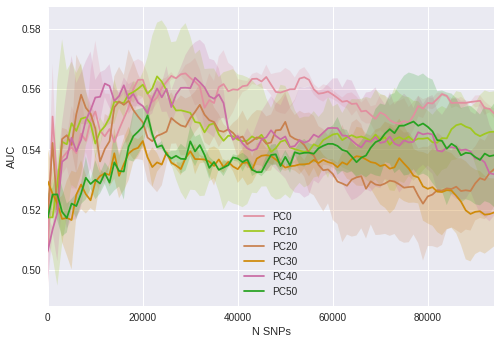

In [104]:
if __name__ == '__main__':

    snp_data, pheno = util.load_data("/home/vcabeli/Documents/data/BP_final/BP.B37-final")
    #imputed data (données par chromosome: "/home/vcabeli/Documents/data/BP_final_imputed/0.5_info/merged/plink/bedbimfam/BP.B37-imputed.chr{}.merged.1KG_P3.EURMAF0.005.0.5_info".format(chrom)
    n_iter = 2
    threshs = range(10, 95000, 1000)
    thresh_LD = 5
    nb_pc_tot=51
    time = range(10,95000,1000)
    get_color = lambda : "#" + "".join(np.random.choice(list("02468acef"), size=6))
    step = 10
    ############
    for PC in range(0,nb_pc_tot,step):
        print "========================= {} PCs =========================".format(PC)
        res_pval=iterate(snp_data, pheno,n_iter,threshs,thresh_LD,PC)
        df = pd.DataFrame(res_pval)
        df.to_csv("{}_res.csv".format(PC), header=None,index=None)
        for i in range(len(time)):
            res_pval[res_pval[:,i] == 0,i] = np.nan
            res_pval[np.isnan(res_pval[:,i]),i] = np.nanmedian(res_pval[:,i])
        sns.tsplot(np.power(res_pval,1),color=get_color(),ci=[0,95],time=time, condition="PC{}".format(PC),estimator=np.mean)

    sns.plt.ylabel('AUC')
    sns.plt.xlabel('N SNPs')
    sns.plt.savefig("fct_pc.pdf", format="pdf")

    print "Wrote {}.".format("fct_pc.pdf")
    plt.show()

In [32]:
res_0_PC = np.loadtxt('/home/vcabeli/stage/curve_analysis/beta/result/2/resultat/prs_low_ld_5.res',delimiter=",")
res_2_PC = np.loadtxt('/home/vcabeli/stage/curve_analysis/iscore/result/2_iscore/resultat/prs_low_ld_5.res',delimiter=",")
res_10_PC = np.loadtxt('/home/vcabeli/stage/curve_analysis/combined/result/2_combined/resultat/prs_low_ld_5.res',delimiter=",")
res_20_PC = np.loadtxt('/home/vcabeli/stage/curve_analysis/Pvalue/result/2/resultat/prs_low_ld_5.res',delimiter=",")


liste=[res_0_PC,res_2_PC,res_10_PC,res_20_PC]
liste_pc=["beta","iscore","combined","Pvalue"]
time = range(10,95000,500)
get_color = lambda : "#" + "".join(np.random.choice(list("02468acef"), size=6))

In [30]:

len(res_20_PC)

100

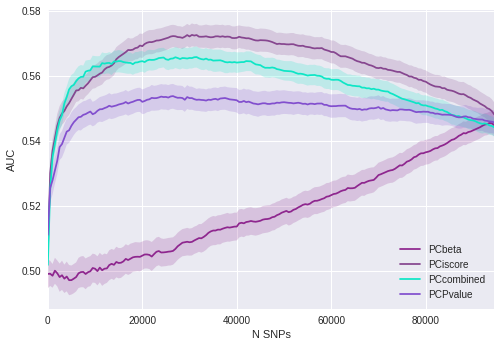

In [35]:

for PC,ele in enumerate(liste):
    for i in range(len(time)):
        ele[ele[:,i] == 0,i] = np.nan
        ele[np.isnan(ele[:,i]),i] = np.nanmedian(ele[:,i])
    sns.tsplot(np.power(ele,1),color=get_color(),ci=[0,95],time=time, condition="PC{}".format(liste_pc[PC]),estimator=np.mean)

sns.plt.ylabel('AUC')
sns.plt.xlabel('N SNPs')
#sns.plt.savefig("fct_pc.pdf", format="pdf")

#print "Wrote {}.".format("fct_pc.pdf")
plt.show()

In [200]:
snp_data, pheno = util.load_data("/home/vcabeli/Documents/data/BP_final/BP.B37-final")
    #imputed data (données par chromosome: "/home/vcabeli/Documents/data/BP_final_imputed/0.5_info/merged/plink/bedbimfam/BP.B37-imputed.chr{}.merged.1KG_P3.EURMAF0.005.0.5_info".format(chrom)
threshs = range(10, 95000, 1000)
thresh_LD = 5
cmd_extract_low_ld_snps = "plink --bfile {} --extract {} --make-bed --out {}".format("/home/vcabeli/Documents/data/BP_final/BP.B37-final",
                                                                                     "L2_thresh_{}_BP.extract".format(thresh_LD),
                                                                                     "low_ld")
print cmd_extract_low_ld_snps
p = subprocess.Popen(cmd_extract_low_ld_snps, shell=True)
assert(p.wait()==0)

plink_prune("low_ld")


Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.


In [201]:
# Covariables

cmd_smart_pca2 = "smartpca.perl -i {} -a {} -b {} -o {} -p {} -e {} -l {} -k {} -t {} -m {}".format("low_ld_pruned.bed",
                                                                                               "low_ld_pruned.bim",
                                                                                               "low_ld_pruned.fam",
                                                                                               "low_ld_pruned.pca",
                                                                                               "low_ld_pruned.plot",
                                                                                               "low_ld_pruned.eval",
                                                                                               "low_ld_pruned.log",
                                                                                               2, 2, 0)
print cmd_smart_pca2
p = subprocess.Popen(cmd_smart_pca2, shell=True)
p.wait()


write_cov_file("low_ld_pruned.pca.evec",2)
save_strat("low_ld_pruned.pca.evec", "low_ld{}".format(thresh_LD)) #OUTPUT LINE



smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 2 -t 2 -m 0
Wrote low_ld_pruned.cov


In [202]:
# #### Split training / testing datasets
train_idces = np.random.choice(np.arange(snp_data.row_count), size=int(snp_data.row_count*0.5), replace=False)
test_idces = np.setdiff1d(np.arange(snp_data.row_count), train_idces, assume_unique=True)




training_sample_out = "training_samples.keep"

with open(training_sample_out, 'w') as f:
    for i in train_idces:
        f.write(pheno['iid'][i][0] + "\t" + pheno['iid'][i][1])
        f.write("\n")



# #### Build training set bed bim fam


#creation fichier plink (bam,bed,fam) avec les données d'apprentissage seulement
cmd_keep_plink = "plink --bfile {} --keep {} --make-bed --out {}".format("/home/vcabeli/Documents/data/BP_final/BP.B37-final",
                                                                         training_sample_out,
                                                                         "training_set")
print cmd_keep_plink
p = subprocess.Popen(cmd_keep_plink, shell=True)
p.wait()



976
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set


0

In [206]:
##################LD-score
cmd_CM ='''plink --bfile {} --cm-map 1000GP_Phase3/genetic_map_@_combined_b37.txt --make-bed --out {}'''.format("training_set","training_CM")
print cmd_CM
p = subprocess.Popen(cmd_CM, shell=True)
p.wait()

cmd_ldscore = '''python2 ldsc.py --bfile {} --l2 --ld-wind-cm 1 --out {}'''.format("training_CM","training_LD")
print cmd_ldscore
p = subprocess.Popen(cmd_ldscore, shell=True)
p.wait()

cmd_unzip="gunzip {}.l2.ldscore.gz".format("training_LD")
p = subprocess.Popen(cmd_unzip, shell=True)
p.wait()

LD_scores = pd.read_table("{}.l2.ldscore".format("training_LD"), delim_whitespace=True)

sorted_snps_ld_score = np.argsort(LD_scores.L2)
sorted_snps_ld_score

plink --bfile training_set --cm-map 1000GP_Phase3/genetic_map_@_combined_b37.txt --make-bed --out training_CM
python2 ldsc.py --bfile training_CM --l2 --ld-wind-cm 1 --out training_LD


0         183363
1         240431
2         155670
3         142697
4          11260
5          56827
6         219686
7         208656
8           3011
9         189514
10        188921
11        196060
12        210639
13         39564
14         29909
15        120029
16         86813
17         56644
18         38336
19         57077
20         55929
21        139638
22        132865
23         82568
24        146583
25        225975
26        205117
27        164196
28         57076
29        228786
           ...  
250110     89699
250111    117592
250112     89687
250113     89689
250114    117612
250115     89880
250116     89895
250117     90003
250118     89977
250119    117624
250120     89608
250121     89634
250122    117588
250123    117627
250124     89965
250125     89975
250126     89682
250127     89768
250128     89799
250129     89909
250130     89905
250131     89828
250132     89722
250133     89740
250134     89743
250135     89758
250136     89753
250137     898

In [207]:
##################I-score
snp_data_iscore, pheno_iscore = util.load_data("training_set")
i_scores_classification = util.get_i_scores_binary()
sorted_snps_iscore=np.argsort(-i_scores_classification)
sorted_snps_iscore

Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 229 cases and 747 controls.
Loaded 976 samples and 250140 SNPs.
Computing I scores of 250140 SNPs, for 229 case samples and 747 controls...
Done.


array([203827, 203829,  94566, ..., 127153, 176526,  40831])

In [208]:
# clump les SNPs pour garder les SNPs indépendantes 

cmd_prune = """plink --bfile {}  --indep-pairwise 50 5 0.2 --out {}""".format("training_set", "test_prune")
p = subprocess.Popen(cmd_prune, shell=True)
assert(p.wait() == 0)
pruned_res = pd.read_table("test_prune.prune.in", delim_whitespace=True,header=None)
pruned_snps =set(pruned_res[0])
sorted_snps_iscore = np.array([i for i in sorted_snps_iscore if snp_data.col[i] in pruned_snps])
print sorted_snps_iscore
sorted_snps_ld_score = np.array([i for i in sorted_snps_ld_score if snp_data.col[i] in pruned_snps])
print sorted_snps_ld_score

[124992 182873 197606 ..., 217824 167675  40831]
[183363 240431 155670 ...,  89744 117465 117514]


In [210]:
print len(sorted_snps_ld_score)
print len(sorted_snps_iscore)

79308
79308


In [211]:
cmd_second_gwas = "plink --bfile {} --logistic sex beta hide-covar --covar {} --covar-name PC1-PC{} --out {}".format("training_set",
                                                                                                           "low_ld_pruned.cov",
                                                                                                            2,
                                                                                                           "low_ld")
print cmd_second_gwas
p = subprocess.Popen(cmd_second_gwas, shell=True)
p.wait()
low_ld_res = pd.read_table("low_ld.assoc.logistic", delim_whitespace=True)

# #### Coded genotype (hardy-weinberg)
# 
# With sufficiently large cohorts, traning and test sets should have the same MAFs. 
# The coded genotype is computed on the whole dataset.




G_hw = snp_data.val.copy()

MAFs = np.nansum(2-G_hw, axis=0, ) / (np.count_nonzero(~np.isnan(G_hw), axis=0) * 2)
G_hw = (2-G_hw - 2*MAFs)/np.sqrt(2*MAFs*(1-MAFs))


plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC2 --out low_ld


In [213]:
threshs = range(10, 79308, 1000)

# ### Compute PRS

isc_low_ld = polygen_score_sign(G_hw, sorted_snps_iscore,
                                        threshs,
                                        test_idces, pheno,
                                        low_ld_res.BETA)
LD_low_ld = polygen_score_sign(G_hw, sorted_snps_ld_score,threshs,test_idces, pheno,low_ld_res.BETA)

100%|██████████| 80/80 [00:04<00:00, 18.84it/s]


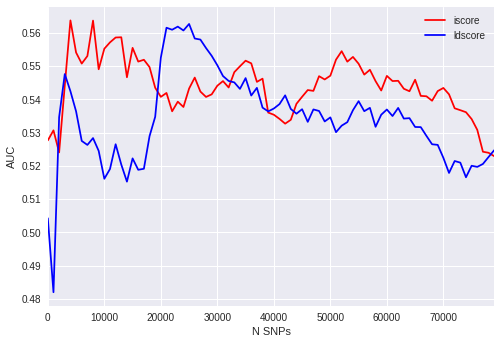

In [214]:
time = range(10,79308,1000)
sns.tsplot(np.power(isc_low_ld,1),color='red',ci=[0,95],time=time, condition="iscore",estimator=np.mean)
sns.tsplot(np.power(LD_low_ld,1),color='blue',ci=[0,95],time=time, condition="ldscore",estimator=np.mean)
sns.plt.ylabel('AUC')
sns.plt.xlabel('N SNPs')

plt.show()